## Model Evaluation
Section 5.1 in the paper

In [1]:
import os
wd = os.path.normpath(os.getcwd() + '/..')
os.chdir(wd)
os.getcwd()

'C:\\Users\\Fitogether\\Workspace\\research-footballcpd'

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from src.myconstants import *
sns.set(font_scale=1.5)

### Loading the Human-annoatated formation data

Formation and role change-point labels annotated by domain experts

In [3]:
form_tags_true = pd.read_csv('data/form_tags_true.csv', header=0)
form_tags_true

,activity_id,session,start_time,end_time,formation
0,43,1,0,46,4231
1,43,2,0,12,4231
2,43,2,12,32,442
3,43,2,32,39,442
4,43,2,39,49,442
...,...,...,...,...,...
142,436,2,0,8,442
143,436,2,8,20,4231
144,436,2,20,25,4231
145,436,2,25,43,4231


### Formatting the predicted formation data
Format the formation label per role period predicted by FootballCPD

In [4]:
header = ['activity_id', 'session', 'player_period', 'form_period', 'role_period', 'start_time', 'end_time']
fgp_files = os.listdir('data/fgp_avg')

role_period_list = []
for file in fgp_files:
    activity_id = int(file.split('.')[0])
    path = f'data/fgp_avg/{file}'
    fgp_df = pd.read_csv(path, header=0, encoding='utf-8-sig')
    grouped = fgp_df.groupby('role_period')
    match_role_periods = grouped.first()[['session', 'player_period', 'form_period', 'gametime']]
    match_role_periods['activity_id'] = activity_id
    match_role_periods['start_time'] = match_role_periods['gametime'].apply(lambda x: int(x[:2]))
    match_role_periods['end_time'] = grouped['gametime'].last().apply(lambda x: int(x[:2]))
    match_role_periods.reset_index(inplace=True)
    role_period_list.append(match_role_periods[header])
    
role_periods = pd.concat(role_period_list, axis=0, ignore_index=True).astype(int)
role_periods

,activity_id,session,player_period,form_period,role_period,start_time,end_time
0,245,1,1,1,1,0,18
1,245,1,1,2,2,18,46
2,245,2,2,3,3,0,13
3,245,2,3,4,4,13,40
4,245,2,4,4,5,40,48


Note: Since we only share the data from a sample match 245 due to the security issue, the above code generates the records from just the single match 245. The records of the entire role periods used in this experiment are as follows.

In [5]:
role_periods = pd.read_csv('data/role_periods.csv', header=0)
role_periods

,activity_id,session,player_period,form_period,role_period,start_time,end_time
0,43,1,1,1,1,0,46
1,43,2,2,2,2,0,12
2,43,2,3,2,3,12,32
3,43,2,4,2,4,32,39
4,43,2,5,2,5,39,49
...,...,...,...,...,...,...,...
147,436,1,1,1,2,31,47
148,436,2,2,2,3,0,20
149,436,2,3,2,4,20,25
150,436,2,4,2,5,25,43


In [6]:
form_periods = pd.read_pickle('data/form_periods.pkl')
form_tags_pred = pd.merge(role_periods, form_periods[['activity_id', 'form_period', 'formation']])
form_tags_pred

,activity_id,session,player_period,form_period,role_period,start_time,end_time,formation
0,43,1,1,1,1,0,46,4231
1,43,2,2,2,2,0,12,442
2,43,2,3,2,3,12,32,442
3,43,2,4,2,4,32,39,442
4,43,2,5,2,5,39,49,442
...,...,...,...,...,...,...,...,...
147,436,1,1,1,2,31,47,442
148,436,2,2,2,3,0,20,4231
149,436,2,3,2,4,20,25,4231
150,436,2,4,2,5,25,43,4231


### (1) Formation Prediction Accuracy

In [7]:
mins_header = ['activity_id', 'session', 'start_time', 'formation']

mins_true = []
for i in form_tags_true.index:
    period_true = form_tags_true.iloc[i]
    start_time = period_true['start_time']
    end_time = period_true['end_time']
    duration = end_time - start_time
    period_mins_true = pd.DataFrame(
        np.repeat(period_true[mins_header].values[np.newaxis], duration, axis=0), columns=mins_header
    )
    period_mins_true['start_time'] = np.arange(start_time, end_time)
    mins_true.append(period_mins_true)
    
mins_true = pd.concat(mins_true, axis=0, ignore_index=True)
mins_true['formation'] = mins_true['formation'].astype(str)
mins_true

,activity_id,session,start_time,formation
0,43,1,0,4231
1,43,1,1,4231
2,43,1,2,4231
3,43,1,3,4231
4,43,1,4,4231
...,...,...,...,...
2675,436,2,44,4231
2676,436,2,45,4231
2677,436,2,46,4231
2678,436,2,47,4231


In [8]:
mins_pred = []
for i in form_tags_pred.index:
    period_pred = form_tags_pred.iloc[i]
    start_time = period_pred['start_time']
    end_time = period_pred['end_time']
    duration = end_time - start_time
    period_mins_pred = pd.DataFrame(
        np.repeat(period_pred[mins_header].values[np.newaxis], duration, axis=0), columns=mins_header
    )
    period_mins_pred['start_time'] = np.arange(start_time, end_time)
    mins_pred.append(period_mins_pred)
    
mins_pred = pd.concat(mins_pred, axis=0, ignore_index=True)
mins_pred

,activity_id,session,start_time,formation
0,43,1,0,4231
1,43,1,1,4231
2,43,1,2,4231
3,43,1,3,4231
4,43,1,4,4231
...,...,...,...,...
2675,436,2,44,4231
2676,436,2,45,4231
2677,436,2,46,4231
2678,436,2,47,4231


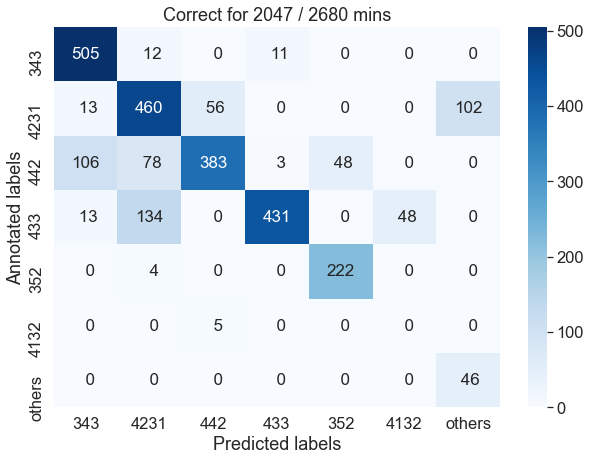

In [9]:
formations = ['343', '4231', '442', '433', '352', '4132', 'others']
conf_mat = confusion_matrix(
    mins_true['formation'].values, mins_pred['formation'].values, labels=formations
)
conf_mat = pd.DataFrame(conf_mat, index=formations, columns=formations)
mins_common = pd.merge(mins_true, mins_pred)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1.5)
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='3d', annot_kws={"size": 17, })
plt.title(f"Correct for {len(mins_common)} / {len(mins_true)} mins")
plt.xlabel("Predicted labels")
plt.ylabel("Annotated labels")
# plt.savefig('form_conf.pdf',bbox_inches='tight')

### (2) Role Change-Point Detection Accuracy